# FLDPLN Model for Verdigris river

In [2]:
import os
import time

# import the mapping module in the fldpln package
# import DASK libraries for parallel mapping
from dask.distributed import Client, LocalCluster
from dask import visualize

# import the mapping and gauge modules from the fldpln package
from fldpln.mapping import *
from fldpln.gauge import *

In [3]:

# tiled library folder
libFolder =  'C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/tiled_snz_library' # verdigris
# libFolder =  'E:/fldpln/sites/verdigris_10m/tiled_snz_library'

# libraries to be mapped
#allLibNames = ['seglib_fldpln'] # wildcat
allLibNames = ['lib_fldsensing'] # verdigris

# Set output folder
outMapFolder = 'C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/maps'
# outputFolder = 'E:/fldpln/sites/verdigris_10m/maps'

# Code for snapping stage to FSP - Li

We can also get event maximum stage directly from USGS NWIS to check and verify the historic crests obtained from NOAA/NWS AHPS. Note that those stages are in feet and we need to convert them to stage elevation before using it in mapping.

In [4]:
# Wildcat Creek 3 USGS gauges (in the order from upstream to downstream)
usgsIds = ['06879805','06879810','06879815'] # USGS IDs for Wildcat Creek gauges
ahpsIds = ['WKCK1','MWCK1','MSTK1'] # AHPS IDs for Wildcat Creek gauges

# A period between two dates: Wildcat Creek Sep.3 2018 flood event
instStages = GetUsgsGaugeStageFromWebService(usgsIds,startDate='2018-09-02',endDate='2018-09-04')
print(instStages)

# find the max stage within the time period
maxStages = instStages.groupby(['stationid'],as_index=False).agg({'stage_ft':'max'})
# find the most recent time with the max stage
tdf = pd.merge(instStages, maxStages, how='inner', on=['stationid','stage_ft'])
gaugeStagesFromNwis = tdf.groupby(['stationid'], as_index=False).agg({'stationid':'first','stage_ft':'first','stage_time':'max'})
print(gaugeStagesFromNwis)

c:\users\hobbe\miniconda3\envs\fldpln2\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'waterservices.usgs.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\users\hobbe\miniconda3\envs\fldpln2\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'waterservices.usgs.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\users\hobbe\miniconda3\envs\fldpln2\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nwis.waterservices.usgs.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warni

    stationid  stage_ft                     stage_time
0    06879805      6.87  2018-09-02T00:00:00.000-05:00
1    06879805      6.87  2018-09-02T00:15:00.000-05:00
2    06879805      6.87  2018-09-02T00:30:00.000-05:00
3    06879805      6.87  2018-09-02T00:45:00.000-05:00
4    06879805      6.87  2018-09-02T01:00:00.000-05:00
..        ...       ...                            ...
812  06879815      5.73  2018-09-04T22:45:00.000-05:00
813  06879815      5.73  2018-09-04T23:00:00.000-05:00
814  06879815      5.72  2018-09-04T23:15:00.000-05:00
815  06879815      5.72  2018-09-04T23:30:00.000-05:00
816  06879815      5.71  2018-09-04T23:45:00.000-05:00

[817 rows x 3 columns]
  stationid  stage_ft                     stage_time
0  06879805     25.97  2018-09-03T04:45:00.000-05:00
1  06879810     28.29  2018-09-03T07:00:00.000-05:00
2  06879815     25.18  2018-09-03T08:30:00.000-05:00


In [5]:
# Synthetic FSP gauges from NWC reach stage
# gaugeStageFileName = 'wildcat_gauges.xlsx'
# sheetName = 'ReachStageAsDof' 

cwd = os.getcwd()
print(cwd)
gaugeStageFileName = 'VerdigrisGauges.xlsx'

sheetName = '2019Flood' 

# read gauge file
gaugeStages = pd.read_excel(gaugeStageFileName, sheet_name=sheetName) # 3 gauges
print(gaugeStages)

# Need to calculate gauge stage elevation if necessary!

# keep only necessary fields from gauges
keptFields = ['stationid','x','y','stage_elevation']
gaugeWithStageElevations = gaugeStages[keptFields]
print(gaugeWithStageElevations)

c:\Users\hobbe\Documents\Thesis\fldpln\examples\notebooks
        stationid                             name organization stype  \
0        07170990   VERDIGRIS R AT COFFEYVILLE, KS         USGS    ST   
1           CFVK1                  Coffeyville, KS         AHPS    ST   
2  07170500,IDPK1  VERDIGRIS R AT INDEPENDENCE, KS    USGS,AHPS    ST   
3  07169500,FRNK1           FALL R AT FREDONIA, KS    USGS,AHPS    ST   
4  07166500,ATOK1       VERDIGRIS R NR ALTOONA, KS    USGS,AHPS    ST   

   datum_elevation  vdatum  to_navd88              x             y  stage  \
0           675.00  NGVD29   0.446193  803191.638090  4.100896e+06  35.95   
1           699.63  NGVD29   0.459317  799235.783244  4.106982e+06  25.80   
2           716.63  NGVD29   0.462597  794776.617849  4.124860e+06  45.35   
3           819.09  NGVD29   0.459317  779884.869637  4.155983e+06  31.77   
4           796.65  NAVD88   0.000000  793849.397926  4.158843e+06  21.93   

   stage_elevation                      

In [6]:
# snap gauges to FSPs on-the-fly
print('Snap gauges to FSPs ...')
print(f'Number of gauges: {len(gaugeWithStageElevations.index)}')

# FLDPLN libraries to whose FSPs gauges are sanpped. All the libraries by default but can be a subset
libs2Map = allLibNames

# snap the gauges to FSPs. 
# Fields 'StrOrd','DsDist','SegId','FilledElev'are used for interpolating other FSP DOF
# Note that 'lib_name','FspX', 'FspY' together uniquely identify a FSP (as there are overlapping FSPs between libraries)!
gaugeFspDf = SnapGauges2Fsps(libFolder,libs2Map,gaugeWithStageElevations,snapDist=350,gaugeXField='x',gaugeYField='y',fspColumns=['FspX','FspY','StrOrd','DsDist','SegId','FilledElev']) 
print(gaugeFspDf)

# calculate gauge FSP's DOF
gaugeFspDf['Dof'] = gaugeFspDf['stage_elevation'] - gaugeFspDf['FilledElev']

# keep only necessary columns for gauge FSPs
gaugeFspDf = gaugeFspDf[['lib_name','FspX','FspY','StrOrd','DsDist','SegId','FilledElev','Dof']] # Note that 'lib_name','FspX', 'FspY' together uniquely identify a FSP!!!

# show info
print(f'Number of snapped gauge FSPs: {len(gaugeFspDf)}')
# Find libs where the gauges are snapped to, and they are the actual libs to map
libs2Map = gaugeFspDf['lib_name'].drop_duplicates().tolist()
print(f'Libraries gauges snapped to: {libs2Map}')
print(gaugeFspDf)

#
# save snapped gauges to CSV file for checking
# gaugeFspDf.to_csv(os.path.join(outputFolder, 'SnappedGauges.csv'), index=False)

Snap gauges to FSPs ...
Number of gauges: 5
   index       stationid              x             y  stage_elevation  \
0      0        07170990  803191.638090  4.100896e+06       711.396193   
1      1           CFVK1  799235.783244  4.106982e+06       725.889317   
2      2  07170500,IDPK1  794776.617849  4.124860e+06       762.442597   
3      3  07169500,FRNK1  779884.869637  4.155983e+06       851.319317   
4      4  07166500,ATOK1  793849.397926  4.158843e+06       818.580000   

   d2NearestFsp      FspX       FspY  StrOrd         DsDist  SegId  \
0     36.878830  803215.0  4100925.0     1.0    1931.959595  196.0   
1     30.052172  799265.0  4106975.0     1.0   19433.565645  186.0   
2     12.474286  794765.0  4124855.0     1.0   56855.915549  177.0   
3      8.132955  779885.0  4155975.0     7.0  139130.362826  146.0   
4     24.511418  793825.0  4158845.0     1.0  124314.736573  165.0   

   FilledElev        lib_name  
0  206.209808  lib_fldsensing  
1  212.937973  lib_fldsens

c:\users\hobbe\miniconda3\envs\fldpln2\Lib\site-packages\fldpln\mapping.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  nearestP2Df = pd.concat([nearestP2Df,t],ignore_index=False)


# Code modification
In FLDPLN code, the procedure first snap and interpolate stage between FSPs and later, given the value, map the corresponding FPPs. For the method proposed, technically this interpolation step should be performed after the RS edge selection and later, deriving the stage that generates the DoF close to zero at the FPP.

*Steps*

1. Load "clean edge" raster
2. Snap raster to .bil or similar
3. Extract X,Y coordinates of edge pixels into a df
4. Open FLDPLN_tiled_tile_index.csv to extract info of .snz tiles and edge pixel locations.

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import rasterio
from rasterio.warp import reproject, Resampling
from collections import defaultdict

In [3]:
# Step 1 and 2
def snap_raster(src_path, ref_path, dst_path):
    with rasterio.open(ref_path) as ref_src:
        ref_transform = ref_src.transform
        ref_crs = ref_src.crs
        ref_width = ref_src.width
        ref_height = ref_src.height

    with rasterio.open(src_path) as src:
        profile = src.profile
        profile.update({
            'crs': ref_crs,
            'transform': ref_transform,
            'width': ref_width,
            'height': ref_height
        })

        with rasterio.open(dst_path, 'w', **profile) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=ref_transform,
                    dst_crs=ref_crs,
                    resampling=Resampling.nearest
                )
                
src_path = 'C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/RS/ConEstimate.tif'
ref_path = 'C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/bil/dem.bil'
dst_path = 'C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/RS/true_edge_alig1.tif'                
snap_raster(src_path, ref_path, dst_path)

In [4]:
# Step 3
def extract_coordinates(raster_path, value):
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        transform = src.transform

    rows, cols = np.where(data == value)
    xs, ys = rasterio.transform.xy(transform, rows, cols)

    df = pd.DataFrame({
        'X_coord': xs,
        'Y_coord': ys
    })
    return df

snapped_raster_path = dst_path
value_to_extract = 1
RS_edges = extract_coordinates(snapped_raster_path, value_to_extract)

In [5]:
# Step 4.1
## Load the tile index CSV file
tile_index_path = 'C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/tiled_snz_library/FLDPLN_tiled_tile_index.csv'
tile_index_df = pd.read_csv(tile_index_path)
cell_size = 10
hcs = cell_size / 2

## Function to find the tile ID for a given FPP coordinate
def find_tile_id_and_indices(x, y, tile_index_df, cell_size):
    for idx, row in tile_index_df.iterrows():
        if row['TileMinX'] < x < row['TileMaxX'] and row['TileMinY'] < y < row['TileMaxY']:
            fpp_col = int((x - (row['FppMinX'] + hcs)) / cell_size)
            fpp_row = int(((row['FppMaxY'] - hcs) - y) / cell_size)
            return row['TileId'], fpp_col, fpp_row
    return None, None, None
    
## Apply the function to each row in the coordinates DataFrame
RS_edges[['TileId', 'FppCol', 'FppRow']] = RS_edges.apply(
    lambda row: pd.Series(find_tile_id_and_indices(row['X_coord'], row['Y_coord'], tile_index_df,cell_size)), axis=1)

## Display the first few rows of the DataFrame with Tile IDs and FppCols/FppRows
print(RS_edges.head())

    X_coord    Y_coord  TileId  FppCol  FppRow
0  789355.0  4147785.0     6.0  1328.0  1130.0
1  793965.0  4147525.0     6.0  1789.0  1156.0
2  793975.0  4147525.0     6.0  1790.0  1156.0
3  785125.0  4147275.0     6.0   905.0  1181.0
4  785135.0  4147275.0     6.0   906.0  1181.0


In [14]:
# Step 4.2
## Function to load a specific .snz (parquet) file based on TileId using pandas
def load_snz_file(tile_id):
    snz_path = f'C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/tiled_snz_library/FLDPLN_tiled_{tile_id}.snz'
    #df=pd.read_parquet(snz_path)
    #df.to_csv('filename.csv')
    return pd.read_parquet(snz_path)

## Get unique tile IDs needed for the coordinates
dummy = RS_edges['TileId'].dropna().unique()
unique_tile_ids = dummy.astype(int)
print('Tiles to load: '+str(unique_tile_ids))
## Load data for each required tile
tile_data = {}
for tile_id in unique_tile_ids:
    tile_data[tile_id] = load_snz_file(tile_id)
print(tile_data)

# Initialize an empty list to store DataFrames
df_list = []

# Loop through each tile_id and its corresponding DataFrame in tile_data
for tile_id, df in tile_data.items():
    # Add a new column 'TileId' to the DataFrame to store the corresponding tile_id
    df['TileId'] = tile_id
    # Append the DataFrame to the list
    df_list.append(df)

# Concatenate all DataFrames in the list into one large DataFrame
combined_df = pd.concat(df_list, ignore_index=True)

# Save the combined DataFrame to a CSV file
combined_df.to_csv('tile_data_combined.csv', index=False)

print("Tile data saved to 'tile_data_combined.csv'")

## Function to get the FspIds and Dtfs for a specific coordinate from the loaded tile data
def get_fspids_and_dtfs_for_coordinate(fpp_col, fpp_row, tile_id, tile_data):
    tile_df = tile_data.get(tile_id)
    if tile_df is not None:
        results = tile_df[(tile_df['FppCol'] == fpp_col) & (tile_df['FppRow'] == fpp_row)]
        if not results.empty:
            return results['FspId'].tolist(), results['Dtf'].tolist(), results['FilledDepth'].tolist()
    return [], [], []

## Apply the data extraction function to each row in the coordinates DataFrame
RS_edges[['FspIds', 'Dtfs', 'FilledDepth']] = RS_edges.apply(
    lambda row: pd.Series(get_fspids_and_dtfs_for_coordinate(row['FppCol'], row['FppRow'], row['TileId'], tile_data)), axis=1)

print(RS_edges.head())

Tiles to load: [ 6 11  5 10 14  9  4 13]
{6:          FspId  FppCol  FppRow        Dtf  FilledDepth
0        14476       0     106  13.587311     0.000000
1        14476       1     106  13.587311     0.012268
2        14476       2     106  13.587311     0.018433
3        14476       3     107  13.587311     0.030792
4        14476       4     107  13.587311     0.054443
...        ...     ...     ...        ...          ...
8295442   2824    1860    1068  14.998138     0.000000
8295443   2824    1874    1312  14.998245     0.000000
8295444   2824    1786    1469  14.998581     0.000000
8295445   2824    1870    1874  14.999130     0.000000
8295446   2824    1837    1890  14.999222     0.000000

[8295447 rows x 5 columns], 11:         FspId  FppCol  FppRow        Dtf  FilledDepth
0       19927       0    1390  13.132675     0.948410
1       19927       1    1389  13.132675     1.372604
2       19927       1    1390  13.132675     0.156128
3       19927       1    1388  13.132675     0

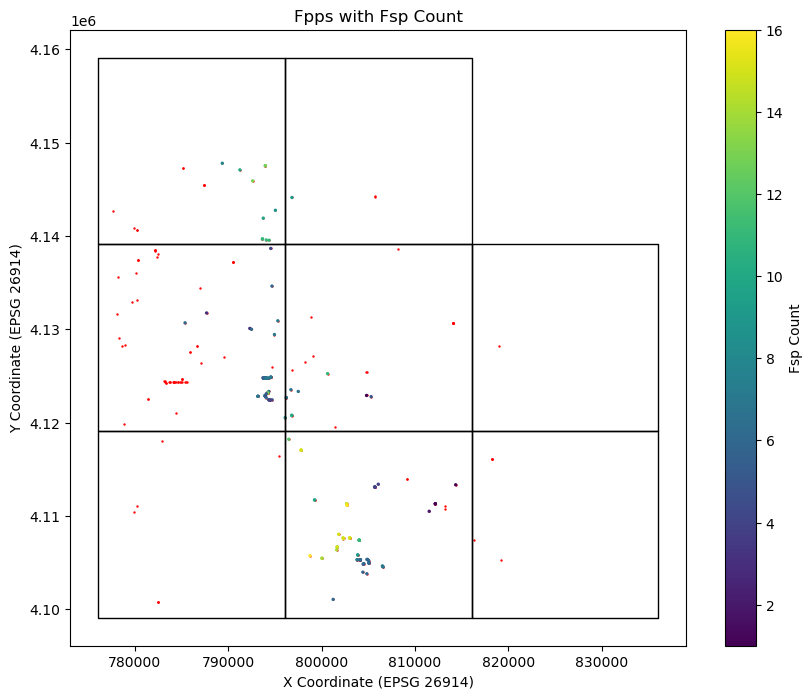

In [12]:
# Step 5 - Map a given Fpp and its Fsp
from shapely.geometry import Polygon

## Filter the DataFrame
RS_edges_filtered = RS_edges
RS_edges_filtered['NumsFSP'] = RS_edges['FspIds'].map(len)
RS_edges_filtered = RS_edges_filtered.drop(RS_edges_filtered[RS_edges_filtered['NumsFSP'] == 0].index)

## Create a GeoDataFrame
gdfRS_edges_filtered = gpd.GeoDataFrame(RS_edges_filtered, geometry=gpd.points_from_xy(RS_edges_filtered['X_coord'], RS_edges_filtered['Y_coord']))
gdfRS_edges = gpd.GeoDataFrame(RS_edges, geometry=gpd.points_from_xy(RS_edges['X_coord'], RS_edges['Y_coord']))
# Set the coordinate reference system (CRS) to EPSG 26914 for NAD UTM 14N. Chamge if required
# It is possible to load .prj from folder for this procedure but we set it here for convenience
gdfRS_edges_filtered.set_crs(epsg=26914, inplace=True)

## Normalize the FspId_count for color mapping
norm = Normalize(vmin=gdfRS_edges_filtered['NumsFSP'].min(), vmax=gdfRS_edges_filtered['NumsFSP'].max())
cmap = plt.cm.viridis

## Plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdfRS_edges.plot(markersize=0.5, ax=ax,color='red')
gdfRS_edges_filtered.plot(column='NumsFSP', cmap=cmap, markersize=2, ax=ax, legend=False, norm=norm)

for i in unique_tile_ids:
    row = tile_index_df.loc[tile_index_df['TileId'] == i, ['TileMinX', 'TileMaxX', 'TileMinY', 'TileMaxY']]
    if not row.empty:
        minx,maxx,miny,maxy = row.iloc[0]

    rectangle = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)])

    # Create a GeoDataFrame
    rec = gpd.GeoDataFrame([1], geometry=[rectangle], crs="EPSG:26914")
    rec.plot(ax=ax, edgecolor='black', markersize=1, facecolor='none')

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Fsp Count')

ax.set_title('Fpps with Fsp Count')
ax.set_xlabel('X Coordinate (EPSG 26914)')
ax.set_ylabel('Y Coordinate (EPSG 26914)')

plt.show()

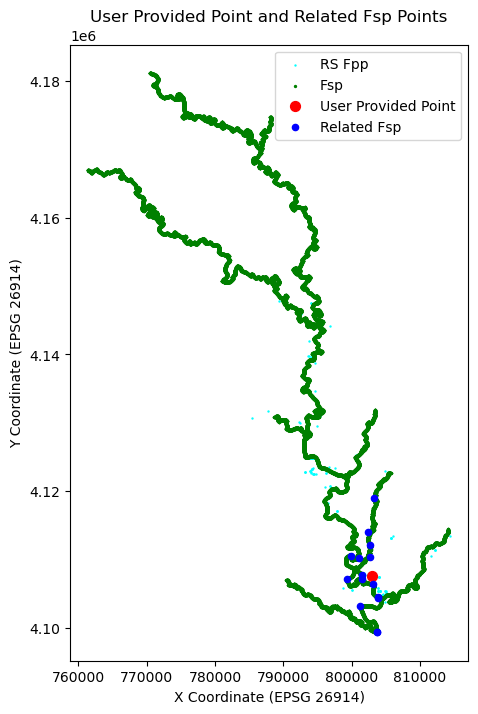

In [13]:
#Step 5.1 - Map a given Fpp and all Fsp related to it
## Function to plot the user-provided point and related Fsp points
def plot_user_point_and_fsps(user_point_index,gdf,fsp_gdf):
    user_point = gdf.iloc[user_point_index]
    related_fsp_ids = user_point['FspIds']
    related_fsps = fsp_gdf[fsp_gdf['FspId'].isin(related_fsp_ids)]
    
    # Plot the data
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Plot the user-provided point
    gdf.plot(ax=ax, color='cyan', markersize=0.5, label='RS Fpp')
    fsp_gdf.plot(ax=ax, color='green', markersize=2, label='Fsp')
    
    user_point_gdf = gpd.GeoDataFrame([user_point], geometry=[user_point.geometry])
    user_point_gdf.plot(ax=ax, color='red', markersize=50, label='User Provided Point')
    
    # Plot the related Fsp points
    related_fsps.plot(ax=ax, color='blue', markersize=20, label='Related Fsp')
    
    # Set plot title and labels
    ax.set_title('User Provided Point and Related Fsp Points')
    ax.set_xlabel('X Coordinate (EPSG 26914)')
    ax.set_ylabel('Y Coordinate (EPSG 26914)')
    
    plt.legend()
    plt.show()

## Example usage: plot the point at index X and its related Fsp points
fsp_info = pd.read_csv('C:/Users/hobbe/Documents/Thesis/fldpln/Data/verdigris_10m_v8/tiled_snz_library/fsp_info.csv')
fsp_gdf = gpd.GeoDataFrame(fsp_info, geometry=gpd.points_from_xy(fsp_info['FspX'], fsp_info['FspY']))
## Set the coordinate reference system (CRS) to EPSG 26914
fsp_gdf.set_crs(epsg=26914, inplace=True)
plot_user_point_and_fsps(100,gdfRS_edges_filtered,fsp_gdf) #Change the number of the pixel here

In [28]:
asdf = gdfRS_edges_filtered[gdfRS_edges_filtered['NumsFSP']==1]
asdf

,X_coord,Y_coord,TileId,FppCol,FppRow,FspIds,Dtfs,FilledDepth,NumsFSP,geometry
140,804815.0,4122905.0,10.0,874.0,1583.0,[2849],[14.176559448242188],[0.7882537841796875],1,POINT (804815.000 4122905.000)
177,814365.0,4113335.0,9.0,1829.0,575.0,[5407],[11.740386962890625],[0.112945556640625],1,POINT (814365.000 4113335.000)
184,812185.0,4111315.0,9.0,1611.0,777.0,[5588],[13.788909912109375],[0.4503631591796875],1,POINT (812185.000 4111315.000)
187,812175.0,4111295.0,9.0,1610.0,779.0,[5588],[13.788909912109375],[0.4471282958984375],1,POINT (812175.000 4111295.000)
188,812185.0,4111295.0,9.0,1611.0,779.0,[5588],[13.788909912109375],[0.41717529296875],1,POINT (812185.000 4111295.000)


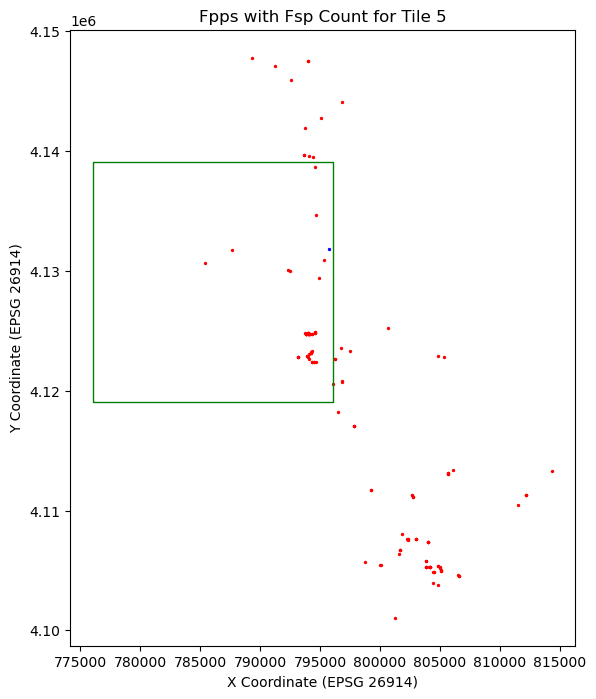

In [15]:
# Visualization - Map Fpp from RS and corresponfing fpp_col,fpp_row in tile extent
from shapely.geometry import Polygon
ids = [27334,27526]
fsp_gdf1 = fsp_gdf.loc[fsp_gdf['FspId'] ==27526]

## Filter the DataFrame
Tile = 5 #User defines the tile number

## Plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdfRS_edges_filtered.plot(color='red', markersize=2, ax=ax)
fsp_gdf1.plot(color='blue', markersize=2, ax=ax)
row = tile_index_df.loc[tile_index_df['TileId'] == Tile, ['TileMinX', 'TileMaxX', 'TileMinY', 'TileMaxY']]
if not row.empty:
    minx,maxx,miny,maxy = row.iloc[0]

rectangle = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)])
rec = gpd.GeoDataFrame([1], geometry=[rectangle], crs="EPSG:26914")
rec.plot(ax=ax, edgecolor='green', markersize=1, facecolor='none')

## Set plot title and labels
ax.set_title('Fpps with Fsp Count for Tile '+str(Tile))
ax.set_xlabel('X Coordinate (EPSG 26914)')
ax.set_ylabel('Y Coordinate (EPSG 26914)')

plt.show()

716      233.807587
1291     233.580566
1422     236.273224
2006     240.770782
2334     227.976059
            ...    
32927    218.448288
33282    219.653946
33283    218.401237
33457    215.191757
33760    218.267044
Name: WSE, Length: 125, dtype: float64


Text(397.907480014812, 0.5, 'Y Coordinate (EPSG 26914)')

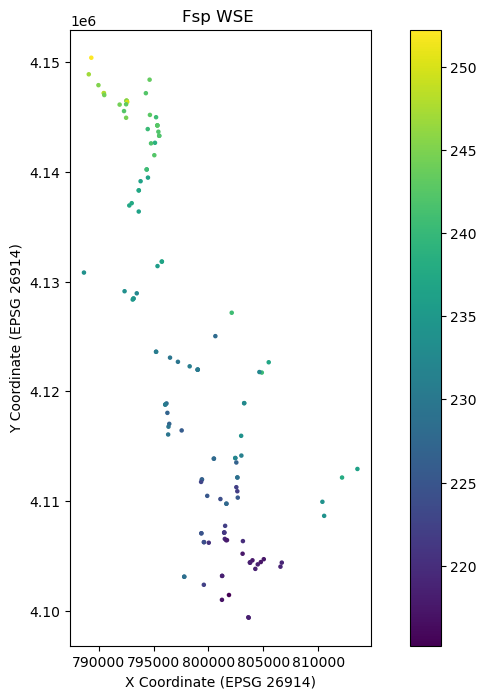

In [33]:
# Step 6 - Store relationship for mapping 
## Drop rows with NumsFSP >= 10 - User defined parameter!
th = 20
gdfRS_edges_filtered_th = gdfRS_edges_filtered[gdfRS_edges_filtered['NumsFSP'] < th]

## Task 2: Store relationships between rows and FspIds
fspid_relationships = defaultdict(lambda: {'count': 0, 'Dtfs': []})

for _, row in gdfRS_edges_filtered_th.iterrows():
    fspids = row['FspIds']
    dtfs = row['Dtfs']
    for fspid, dtf in zip(fspids, dtfs):
        fspid_relationships[fspid]['count'] += 1
        fspid_relationships[fspid]['Dtfs'].append(dtf)


# Compute the median of each FspId's 'Dtfs'
fspid_medians = {fspid: np.median(data['Dtfs']) for fspid, data in fspid_relationships.items()}

# Merge the median values with the coordinates from fsp_info
fsp_gdf1 = fsp_gdf
fsp_gdf1['median'] = fsp_gdf['FspId'].map(fspid_medians)
fsp_gdf1['WSE'] = fsp_gdf1['median'] + fsp_gdf1['FilledElev']
# Filter out FspIds that are not in fspid_medians
fsp_gdf1 = fsp_gdf1.dropna(subset=['WSE'])
print(fsp_gdf1['WSE'])

## Plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fsp_gdf1.plot(column='WSE', markersize=5, ax=ax, legend=True)
#fsp_gdf.plot(ax=ax, markersize=0.5, column='FilledElev')
ax.set_title('Fsp WSE ')
ax.set_xlabel('X Coordinate (EPSG 26914)')
ax.set_ylabel('Y Coordinate (EPSG 26914)')

#plt.show()

In [26]:
gdfRS_edges_filtered

,X_coord,Y_coord,TileId,FppCol,FppRow,FspIds,Dtfs,FilledDepth,NumsFSP,geometry
0,789355.0,4147785.0,6.0,1328.0,1130.0,"[19291, 19523, 19645, 19662, 19928, 20029, 257...","[7.572113037109375, 7.2078094482421875, 7.7060...","[2.307373046875, 2.307373046875, 2.30737304687...",8,POINT (789355.000 4147785.000)
1,793965.0,4147525.0,6.0,1789.0,1156.0,"[19926, 19939, 20815, 24948, 25153, 25731, 258...","[13.988693237304688, 13.86126708984375, 11.888...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11,POINT (793965.000 4147525.000)
2,793975.0,4147525.0,6.0,1790.0,1156.0,"[19644, 19645, 19926, 19939, 20815, 24948, 251...","[14.981689453125, 14.981689453125, 13.91333007...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13,POINT (793975.000 4147525.000)
5,791245.0,4147075.0,6.0,1517.0,1201.0,"[18924, 19644, 19645, 19662, 19928, 20029, 257...","[8.455963134765625, 5.9342041015625, 5.9342041...","[0.007965087890625, 0.007965087890625, 0.00796...",10,POINT (791245.000 4147075.000)
6,792605.0,4145895.0,6.0,1653.0,1319.0,"[18924, 19644, 19645, 19927, 19965, 20092, 255...","[14.590682983398438, 12.353347778320312, 12.35...","[0.5887908935546875, 0.5887908935546875, 0.588...",13,POINT (792605.000 4145895.000)
...,...,...,...,...,...,...,...,...,...,...
238,806555.0,4104565.0,9.0,1048.0,1452.0,"[6790, 6827, 9688, 32858, 32859, 33284, 33761]","[7.413299560546875, 7.413299560546875, 13.6373...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7,POINT (806555.000 4104565.000)
239,806585.0,4104545.0,9.0,1051.0,1454.0,"[6790, 6827, 9688, 32858, 32859, 33284, 33761]","[6.8473663330078125, 6.8473663330078125, 13.36...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7,POINT (806585.000 4104545.000)
240,804415.0,4103975.0,9.0,834.0,1511.0,"[7297, 9688, 32858, 32928, 33284, 33761]","[10.97528076171875, 13.037353515625, 11.875976...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",6,POINT (804415.000 4103975.000)
241,804845.0,4103805.0,9.0,877.0,1528.0,"[7297, 9688, 32858, 32859, 33284, 33761]","[9.195953369140625, 11.99517822265625, 10.2944...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",6,POINT (804845.000 4103805.000)


In [34]:
fsp_gdf

,FspId,FspX,FspY,SegId,FilledElev,DsDist,StrOrd,geometry,median,WSE
0,1,788175,4174775,32,254.768433,159780.274068,8,POINT (788175.000 4174775.000),NaN,NaN
1,2,788165,4174765,32,254.768433,159766.131932,8,POINT (788165.000 4174765.000),NaN,NaN
2,3,788155,4174755,32,254.768433,159751.989797,8,POINT (788155.000 4174755.000),NaN,NaN
3,4,788145,4174745,32,254.768433,159737.847661,8,POINT (788145.000 4174745.000),NaN,NaN
4,5,788135,4174735,32,254.768433,159723.705525,8,POINT (788135.000 4174735.000),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
33770,33771,803755,4099275,197,205.321228,52.426407,1,POINT (803755.000 4099275.000),NaN,NaN
33771,33772,803765,4099265,197,205.314590,38.284271,1,POINT (803765.000 4099265.000),NaN,NaN
33772,33773,803775,4099255,197,205.307022,24.142136,1,POINT (803775.000 4099255.000),NaN,NaN
33773,33774,803785,4099245,197,205.300446,10.000000,1,POINT (803785.000 4099245.000),NaN,NaN
